In [3]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from keras.preprocessing import image
from tensorflow.python.framework import ops
import pickle
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
#from cnn_utils import *

import pandas as pd
import os

c:\users\shantanu\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [84]:
#load dataset
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        #one hot encoding in pandas best method till now
        x=pd.Series(dict[b'labels']) 
        labels=pd.get_dummies(x)
        labels=np.array(labels)
    return (dict[b'data'].reshape(10000,32,32,3),labels)
X_train,Y_train=unpickle("cifar-10-batches-py/data_batch_1")
X_test,Y_test=unpickle("cifar-10-batches-py/test_batch")


(32, 32, 3)


In [246]:
#defenition
def place_hold(n_H0, n_W0, n_C0, n_y):#height width,depth(channel),no of Classes
    X = tf.placeholder(tf.float32, [None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X,Y
    

In [247]:
X,Y=place_hold(32,32,3,10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 32, 32, 3), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 10), dtype=float32)


In [248]:
#shape of input = [batch, in_height, in_width, in_channels]
 #  shape of filter = [filter_height, filter_width, in_channels, out_channels]
def filter_weights():
    W1 = tf.get_variable("W1",[5,5,3,6],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2",[5,5,6,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [249]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,5,5,1], strides = [1,1,1,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 10,activation_fn=None)
    ### END CODE HERE ###

    return Z3

In [250]:
def compute_cost(Z3, Y):
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Z3,labels = Y)
    cost = tf.reduce_mean(cost)
    return cost

In [251]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.000001,
          num_epochs = 100, minibatch_size =10000, print_cost = True):
  
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                           
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = 10,32,32,3        
    n_y = Y_train.shape[1]                           
    costs = []                                        
    X, Y = place_hold(n_H0,n_W0,n_C0,n_y)
    parameters =  filter_weights()
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            minibatch_cost = 0.     
            for i in (0,9999):
                (minibatch_X, minibatch_Y) = X_train[i].reshape(1,32,32,3),Y_train[i].reshape(1,10)
                _ , temp_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                minibatch_cost += temp_cost   
            print("epochs"+str(epoch),minibatch_cost)
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

epochs0 529.4151611328125
epochs1 525.9584655761719
epochs2 522.5664520263672
epochs3 519.1839904785156
epochs4 515.8058776855469
epochs5 512.4325408935547
epochs6 509.0622100830078
epochs7 505.69578552246094
epochs8 502.3317565917969
epochs9 498.9703826904297
epochs10 495.6111755371094
epochs11 492.25477600097656
epochs12 488.9010467529297
epochs13 485.54937744140625
epochs14 482.20082092285156
epochs15 478.8542175292969
epochs16 475.50965881347656
epochs17 472.1671600341797
epochs18 468.8269805908203
epochs19 465.48895263671875
epochs20 462.1525573730469
epochs21 458.81793212890625
epochs22 455.48509216308594
epochs23 452.1537780761719
epochs24 448.8246612548828
epochs25 445.4967041015625
epochs26 442.16981506347656
epochs27 438.8439025878906
epochs28 435.5194854736328
epochs29 432.1964874267578
epochs30 428.8743896484375
epochs31 425.5541229248047
epochs32 422.2349090576172
epochs33 418.91693115234375
epochs34 415.6002197265625
epochs35 412.2843780517578
epochs36 408.9694519042969
e

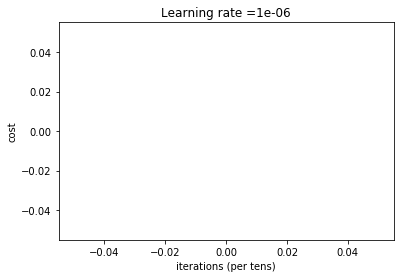

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.0869
Test Accuracy: 0.0827


In [252]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)